This second practical work, on motion estimation, deals with parametric motion estimation. You have to reuse some of the functions you implemented during the first practical work.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [96]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from cv2 import copyMakeBorder,BORDER_REPLICATE

# Parametric estimation
In this second practical work, we will work on parametric estimation, both using direct and indirect methods.
## I- Direct parametric estimation
## I-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

$$\hat{x}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} x(n, m) e^{-i2\pi(\nu_xn + \nu_ym)}$$

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$


Using the definition of DTFT, we have:

$$\hat{b}(\nu_x, \nu_y) = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} b(n, m) e^{-j2\pi(\nu_xn + \nu_ym)}  = \sum_{n=-\infty}^{\infty} \sum_{m=-\infty}^{\infty} a(n+c,m+d) e^{-i2\pi(\nu_xn + \nu_ym)}$$

Now, we can just perform a change of variables, defining $u = n+c$, $v = m+d$:
$$
\hat{b}(\nu_x, \nu_y) = \sum_{u=-\infty}^{\infty} \sum_{v=-\infty}^{\infty} a(u,v) e^{-i2\pi(\nu_x(u-c) + \nu_y(v-d))}$$
$$

\hat{b}(\nu_x, \nu_y) = \sum_{u=-\infty}^{\infty} \sum_{v=-\infty}^{\infty} a(u,v) e^{-i\pi(\nu_x(u) + \nu_y(v))} e^{-i\pi(\nu_x(-c) + \nu_y(-d))} = \hat{a}(\nu_x, \nu_y) e^{i\pi(\nu_x(c) + \nu_y(d))}
$$

Thus:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DFT.

$$\hat{x}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} x(n, m) e^{i2\pi(\frac{k_x}{M} + \frac{k_y}{N})}$$

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

$$\hat{x}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} x(n, m) e^{-i2\pi(\frac{k_x n }{M} + \frac{k_y m }{N})}$$

Using the definition of DFT, we have:

$$\hat{B}(k_x, k_y) = \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n+c, m+d) e^{i2\pi(\frac{k_x n }{M} + \frac{k_y m }{N})}$$

Now, we can again just perform a change of variables, defining $u = n+c$, $v = m+d$:

$$\hat{B}(k_x, k_y) = \sum_{u=0}^{N-1} \sum_{v=0}^{N-1} A(u, v) e^{i2\pi(\frac{k_x (u-c)}{M} + \frac{k_y (v-d)}{N})}$$
$$

\hat{B}(k_x, k_y) = \sum_{u=0}^{N-1} \sum_{v=0}^{N-1} A(u, v) e^{i2\pi(\frac{k_xu}{M} + \frac{k_y v}{N})}  e^{-i2\pi(\frac{k_x (c)}{M} + \frac{k_y (d)}{N})} = \hat{A}(k_x, k_y) e^{-i2\pi(\frac{k_x (c)}{M} + \frac{k_y (d)}{N})}
$$

Thus:
$$
\frac{\hat{A}(k_x, k_y)}{\hat{B}(k_x, k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

Assuming that $a$ and $b$ are $N$ periodic in both dimensions

## I-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [97]:
im_ball = loadmat('ball.mat')['im1']
im_ball = im_ball.astype('float')

im_lena = loadmat('lena.mat')['im1']
im_lena = im_lena.astype('float')

N, M = np.shape(im_ball)
N_lena, m_lena = np.shape(im_lena)

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2720945d930>)

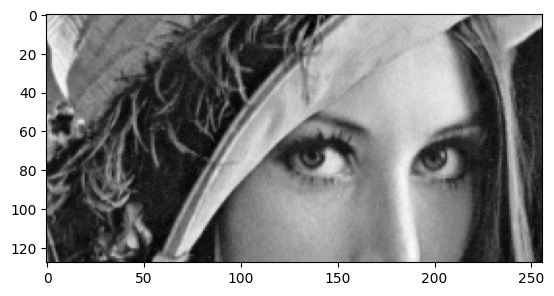

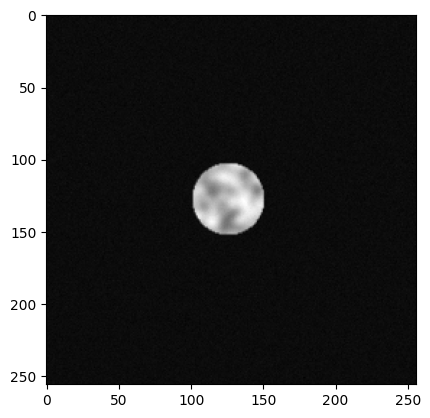

In [98]:

# Potentially add noise to the images

noise = 1#change to true if noise

if noise:
    sigma = 2
    im_lena=  im_lena + np.random.normal(0, sigma, np.shape(im_lena))
    im_ball =  im_ball + sigma*np.random.randn(N, M)

plt.figure(),plt.imshow(im_lena,cmap='gray')
plt.figure(),plt.imshow(im_ball,cmap='gray')

In the following, we apply a translation to the image. To do that, use the applyAffineMotion function which is already pre-implemented.

In [99]:
def fracMc(ref, mvf, outofbound=20):

    [rows, cols] = np.shape(ref)

    # Initial coordinates, used to infer the new coordinates
    mc_c, mc_r = np.meshgrid(np.arange(cols), np.arange(rows))

    mc_r_tmp = mc_r + mvf[:, :, 0]  # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:, :, 1]  # Column coordinates, after the movement

    extension = outofbound
    # ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension,
                             extension, cv2.BORDER_REFLECT)  # Padded image

    # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_r = mc_r_tmp + extension
    # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension

    # Original coordinates, at which we know the data points
    colMeshGrid, rowMeshGrid = np.meshgrid(
        np.arange(cols+2*extension), np.arange(rows+2*extension))

    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1], 2))
    points[:, 0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:, 1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])

    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols, 2))
    points_inter[:, 0] = mc_c.reshape(rows*cols)
    points_inter[:, 1] = mc_r.reshape(rows*cols)

    motcomp = griddata(points, values, points_inter, 'linear')

    motcomp = motcomp.reshape(rows, cols)

    return motcomp

def applyAffineMotion(x, b, B=np.zeros((2, 2)), out=100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2, (M-1)/2+1),
                         np.arange(-(N-1)/2, (N-1)/2+1))

    mvfx = b[0] + B[0, 0]*px + B[0, 1]*py
    mvfy = b[1] + B[1, 0]*px + B[1, 1]*py

    mvf = np.zeros((np.shape(mvfx)[0], np.shape(mvfx)[1], 2))
    mvf[:, :, 1] = mvfx
    mvf[:, :, 0] = mvfy

    y = fracMc(x, mvf, out)
    return y

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x272064f3e20>)

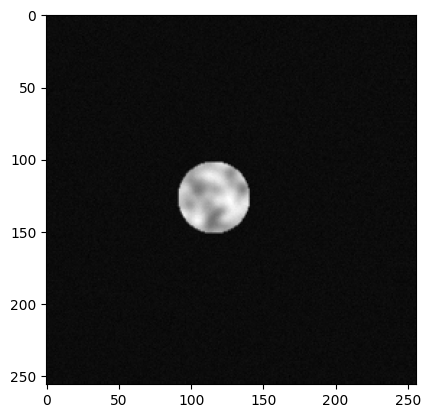

In [100]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

im_ball2 = applyAffineMotion(im_ball, b)
plt.figure(),plt.imshow(im_ball2,cmap='gray')


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x27206d07a60>)

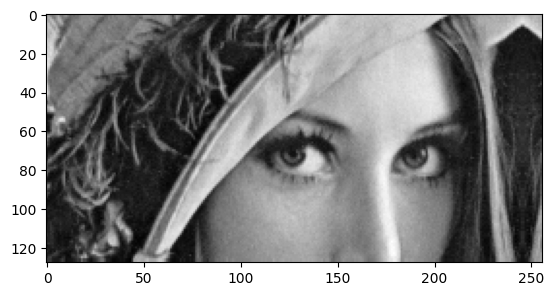

In [101]:
im_lena2 = applyAffineMotion(im_lena, b)
plt.figure(),plt.imshow(im_lena2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

**Answer:**

Given the FFTs of the images, we can use the expression that we found before for the DFTs:

$$
\frac{\hat{A}(k_x, k_y)}{\hat{B}(k_x, k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

This is a 2D array built with complex numbers with unitary modulus, which the phase is:


$$
\phi^{'}(k_x, k_y) = \frac{2\pi(ck_x + dk_y)}{N} \propto ck_x + dk_y
$$

Multiplying this by $\frac{N}{2\pi}$, we arrive at:
$$
\phi(k_x, k_y) = ck_x + dk_y
$$

Thus:
$$
\phi_x(k_x, k_y) = c $$
$$
\phi_y(k_x, k_y) = d
$$




In [102]:
IM1 = np.fft.fft2(im_ball)
IM2 = np.fft.fft2(im_ball2)

IM_LENA = np.fft.fft2(im_lena)
IM_LENA2 = np.fft.fft2(im_lena2)

Compute the phase of the Fourier transform.

In [103]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

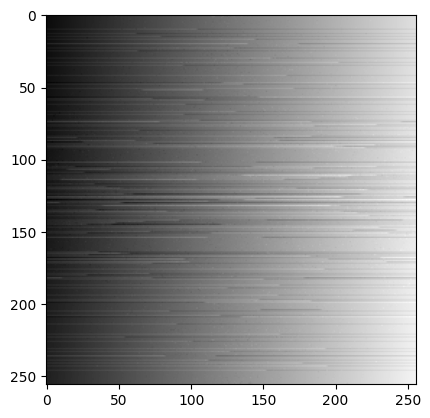

In [104]:
phi = angle2D(IM1/IM2)
phi_lena= angle2D(IM_LENA/IM_LENA2)    
plt.figure()
plt.imshow(phi, cmap='gray')
plt.show()

Display phi. Is it a linear plane and why?

**Answer:**

The Phi is realy similar to a linear plane. If we reduce the noise to close to zero, it's exactly a linear plane, as showed in the previous question the argument of $\frac{\hat{A}(k_x, k_y)}{\hat{B}(k_x, k_y)}$ is proportional to $ck_x + dk_y$, which is linear with respect to $k_x$ and $k_y$.

Text(0.5, 0.92, 'Phi Lena')

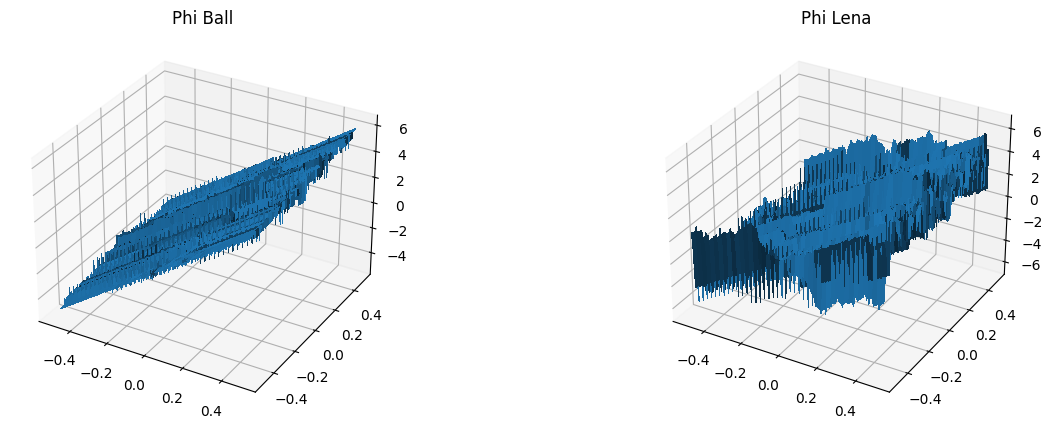

In [105]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)

N_lena,M_lena = IM_LENA.shape

fx_lena, fy_lena = np.meshgrid(np.arange(-(M_lena-1)/2,(M_lena-1)/2+1)/M_lena, np.arange(-(N_lena-1)/2,(N_lena-1)/2+1)/N_lena)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={"projection": "3d"})

surf1 = axes[0].plot_surface(fx, fy, phi, linewidth=0, antialiased=False)
axes[0].set_title('Phi Ball')
surf2 = axes[1].plot_surface(fx_lena, fy_lena, phi_lena, linewidth=0, antialiased=False)
axes[1].set_title('Phi Lena')

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [106]:
phases = [phi,  phi_lena]
gradients = []
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns

    gy = (M[1:, :] - M[:-1, :]) / stepY
    gx = (M[:, 1:] - M[:, :-1]) / stepX
    return gx, gy
for i, phase in enumerate(phases):
    gx, gy = gradient(phase, 1/M, 1/N)
    GX = np.median(gx)
    GY = np.median(gy)
    gradients.append((GX, GY))
    print(f"Gradients for {['phi','phi_lena'][i]}:")
    print(f"GX: {GX}")
    print(f"GY: {GY}")
    print()


Gradients for phi:
GX: 9.98107454712158
GY: 0.8975697483687668

Gradients for phi_lena:
GX: 9.208389296651717
GY: 12.086416996569653



Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

```
fx, fy = np.meshgrid(np.arange(-(M-1)/2, (M-1)/2+1)/M,
                     np.arange(-(N-1)/2, (N-1)/2+1)/N)
```

```
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1], 2)) 
A[:, 0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1]) 
A[:, 1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
```

First, the method computes a meshgrid of all normalized frequencies, in which $
\frac{\hat{A}(k_x, k_y)}{\hat{B}(k_x, k_y)}$ is defined

$$
A = \begin{bmatrix}
k_{x_{11}} & k_{y_{11}} \\
k_{x_{12}} & k_{y_{12}} \\
\vdots     & \vdots     \\
k_{x_{MN}} & k_{y_{MN}}
\end{bmatrix}
$$

Then, we define a least sauqre minimization problem:
$$
\mathrm{x}^{'} = \min_\mathrm{x} ||A\mathrm{x} - \phi||_2^2 
$$

$$
\phi = 
\begin{bmatrix}
k_{x_{11}} & k_{y_{11}} \\
k_{x_{12}} & k_{y_{12}} \\
\vdots     & \vdots     \\
k_{x_{MN}} & k_{y_{MN}}
\end{bmatrix}

\times

\begin{bmatrix}
c \\ 
d
\end{bmatrix}

= 

\begin{bmatrix}
ck_{x_{11}} & dk_{y_{11}} \\
ck_{x_{12}} & dk_{y_{12}} \\
\vdots     & \vdots     \\
ck_{x_{MN}} & dk_{y_{MN}}
\end{bmatrix}
$$

The solution for this can be estimated as:
$$
\mathrm{x}^{'} = [c, d]^T \approx A^{+} b  
$$
* $A^{+}$ is the Moore-Penrose Pseudo-inverse




In [107]:
def medianFilter(x,N):
    z = copyMakeBorder(x, N, N, N, N, BORDER_REPLICATE)
    y = np.zeros(np.shape(x))
    
    for r in range(np.shape(x)[0]):
        for c in range(np.shape(x)[1]):
            tmp = z[r:r+2*N+1,c:c+2*N+1]
            y[r,c] = np.median(tmp)
    return y

In [108]:
def estimate_translation(phi):
    N,M = np.shape(phi)
    fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
    phi = phi - phi[int(N/2+2), int(M/2+2)]
    t = medianFilter(phi, 1)
    A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1], 2))
    A[:, 0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
    A[:, 1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
    b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
    bEst = np.dot(np.linalg.pinv(A), b)
    return bEst

bEstimations = []
for i, phase in enumerate(phases):
    bEst = estimate_translation(phase)
    bEstimations.append(bEst)
    print(f"Translation estimation for {['phi',  'phi_lena'][i]}:")
    print(bEst)
    print()


Translation estimation for phi:
[9.6881635  0.98444274]

Translation estimation for phi_lena:
[8.1612128  0.06906402]



**Relaunch the above code**:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

* **Ball**: For the ball image even with noise is possible to obtain a good approximation of the translation, using both methods


* **Lena**: For the lena image even without noise, we are no longer able to recover the ammount of translation in a good way. We can check that  The reason why this happens is because this image is not periodic as the ball image, so our assumption to recover the translation from the DFT no longer holds.

# Answers



# II-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. **You have to reuse here the functions that you implemented during the first practical work**. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

In [109]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, cur.shape[1], bcol):
                # current block selection

                B = cur[r:r+brow,c:c+bcol] # Block

                # Initialization:
                
                costMin = float('inf')
                
                Rbest = np.zeros(B.shape)
                best_drow, best_dcol = 0, 0
                # Loop on candidate displacement vectors
                for dcol in range(-search, search+1): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search+1):
                        
                        Bref = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]
                        
                        SSD_cost = np.sum((B - Bref)**2)
                        
                        if SSD_cost  < costMin:
                            R_best = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SSD_cost# Save the results if they are better than the previous ones
                            
                            
                mvf[i:i+brow, j:j+bcol, 0] = i-best_drow # Once the loop is over, save the best row displacement field
                mvf[i:i+brow, j:j+bcol, 1] = j-best_dcol# Once the loop is over, save the best column displacement field
                prediction[i:i+brow,j:j+bcol]= Rbest
                
    else: # Regularized search
       for i in range(0, cur.shape[0], brow): # for each block in the current image, find the best corresponding block in the reference image
            for j in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[i:i+brow,j:j+bcol]# Block

                # Initializations          
                costMin = float('inf')
                
                Rbest = np.zeros(B.shape)
                best_drow, best_dcol = 0, 0
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(i,j,brow,bcol,mvf,ref,cur)
                
                #Loop on candidate displacement vectors
                for dcol in range(i-search, i+search, 1): # dcol = candidate displacement vector over the columns
                    for drow in range(j-search, j+search, 1):
                        
                        Bref = ref_extended[drow+search:drow+brow+search,dcol+search:dcol+bcol+search]
                        print(np.array([drow, dcol]).shape)
                        
                        SSD_cost = np.sum((B - Bref)**2) + lamb*np.linalg.norm(np.array([drow, dcol]) - pV) 
                        
                        if SSD_cost  < costMin:
                            R_best = Bref
                            best_drow, best_dcol = drow, dcol
                            costMin = SSD_cost# Save the results if they are better than the previous ones
                            
                            
                mvf[i:i+brow,j:j+bcol,0]= i-best_drow # Once the loop is over, save the best row displacement field
                mvf[j:j+brow,j:j+bcol,1]= j-best_dcol # Once the loop is over, save the best column displacement field
                prediction[i:i+brow,j:j+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : Motion Vector Field. Contains a motion vector for each pixel of the image
    prediction : TYPE
        DESCRIPTION.

    """

    extension = search

    ref_extended = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)  # To avoid border effect

    prediction = np.zeros(np.shape(cur))
    lamb *= brow*bcol

    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))

    # Non-regularized search
    if lamb == 0.:
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+bcol]  # Block #####

                # Initialization:
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                best_drow, best_dcol = 0, 0

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns #####
                for dcol in range(-search, search+1):
                    for drow in range(-search, search+1):

                        temp_block = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]

                        temp_cost = np.sum((B - temp_block)**2)

                        if temp_cost < costMin:  # Save the results if they are better than the previous ones
                            costMin = temp_cost
                            Rbest = temp_block
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest

    else: # Regularized search
        print('Regularization')
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r:r+brow, c:c+bcol]  # Block #####

                # Initialization:
                costMin = np.inf

                Rbest = np.zeros(B.shape)

                best_drow, best_dcol = 0, 0

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns #####
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)
                for dcol in range(-search, search+1):
                    for drow in range(-search, search+1):

                        temp_block = ref_extended[r+drow+search:r+drow+brow+search,c+dcol+search:c+dcol+bcol+search]

                        temp_cost = np.sum((B - temp_block)**2) + lamb * np.sum(([drow, dcol] - pV) ** 2)

                        if temp_cost < costMin:  # Save the results if they are better than the previous ones
                            costMin = temp_cost
                            Rbest = temp_block
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 0] = best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r:r+brow, c:c+bcol, 1] = best_dcol
                prediction[r:r+brow, c:c+bcol] = Rbest

    mvf = -mvf  # For compatibility with standards

    return mvf, prediction



def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x27206a7b6a0>)

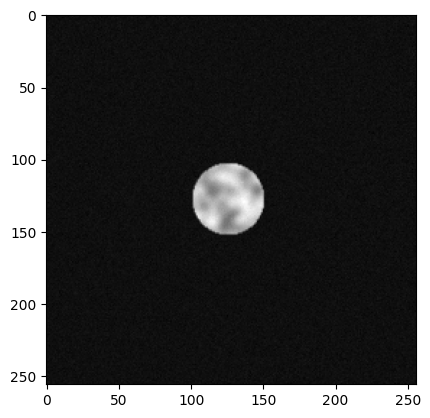

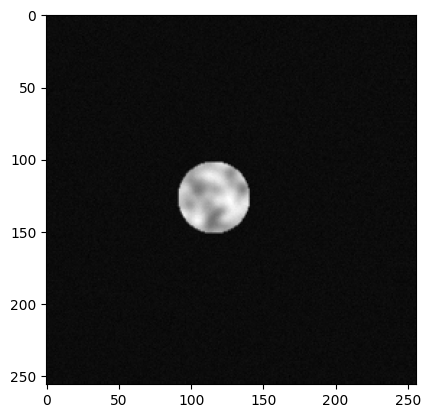

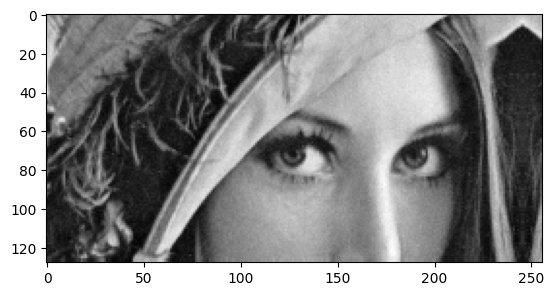

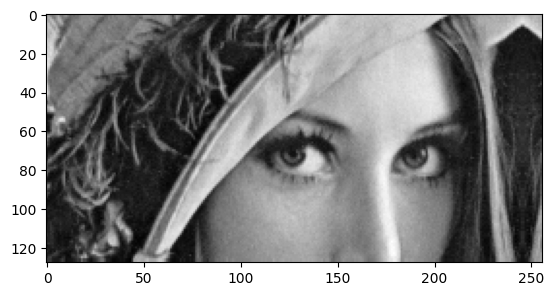

In [110]:
# Potentially add noise to the image
sigma = 2
#add noise to the image
im_noise =  im_ball + np.random.normal(0, sigma, np.shape(im_ball))

#add noise to the image
im_lena_noise =  im_lena + np.random.normal(0, sigma, np.shape(im_lena))

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
B = np.zeros((2,2))

im_noise2 = applyAffineMotion(im_noise, b, B)
plt.figure(),plt.imshow(im_noise,cmap='gray')

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
B = np.zeros((2,2))

im_without_noise = applyAffineMotion(im_ball, b, B)
plt.figure(),plt.imshow(im_without_noise,cmap='gray')

horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
B = np.zeros((2,2))

im_lena_noise2 = applyAffineMotion(im_lena_noise, b, B)
plt.figure(),plt.imshow(im_lena_noise2,cmap='gray')

im_lena2 = applyAffineMotion(im_lena, b, B)
plt.figure(),plt.imshow(im_lena2,cmap='gray')

Regularization
10.0
1.0


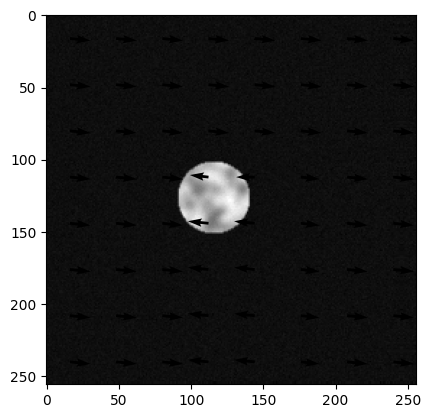

In [111]:


lamb = 5
mvf,prediction = me_ssd(im_noise2,im_ball,32,32,10,lamb)
displayMVF(im_noise2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)


Regularization
10.0
1.0


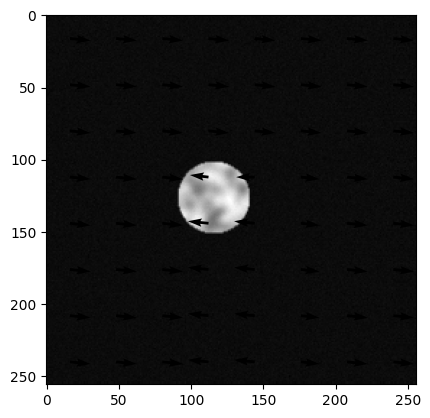

In [112]:
lamb = 5
mvf,prediction = me_ssd(im_without_noise,im_ball,32,32,10,lamb)
displayMVF(im_without_noise,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)


Regularization
10.0
1.0


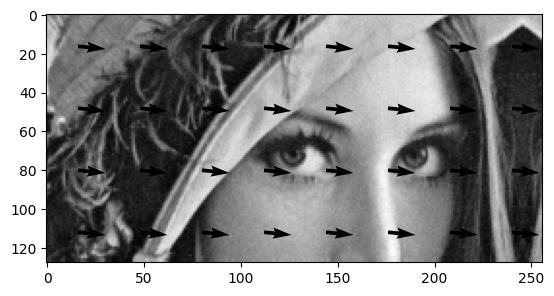

In [113]:
lamb = 400
mvf,prediction = me_ssd(im_lena_noise2,im_lena,32,32,10,lamb)
displayMVF(im_lena_noise2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Regularization
10.0
1.0


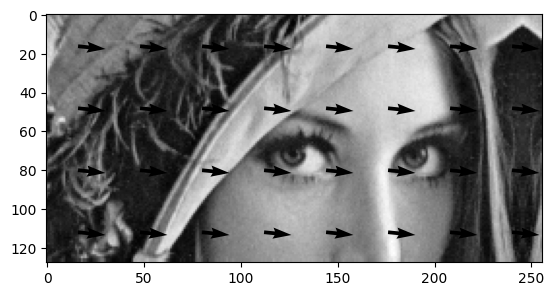

In [114]:
lamb = 400
mvf,prediction = me_ssd(im_lena2,im_lena,32,32,10,lamb)
displayMVF(im_lena2,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

In [115]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=  convolve2d(u, kernel_1, 'same')
        vAvg =  convolve2d(v, kernel_1, 'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - (fx * (fx * uAvg + fy * vAvg + ft)) / (alpha**2 + fx**2 + fy**2)
        v = vAvg - (fy * (fx * uAvg + fy * vAvg + ft)) / (alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

9.819871451717832
0.9637030740514823


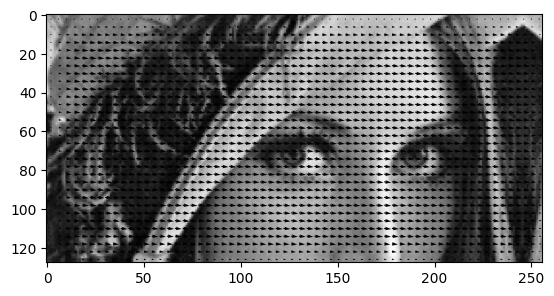

In [116]:
alpha = 1000
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im_lena2, im_lena, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena2,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

9.819764458124409
0.9637245276085543


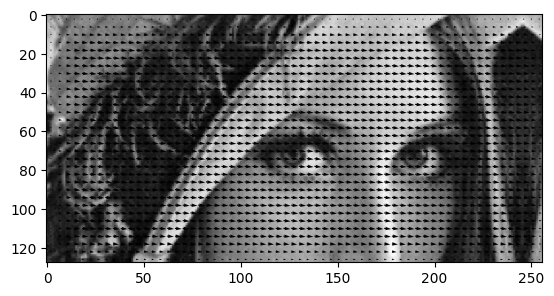

In [117]:
alpha = 1000
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im_lena_noise2, im_lena, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_lena_noise2,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

Regularization
9.874720980560307
0.9927342182669443


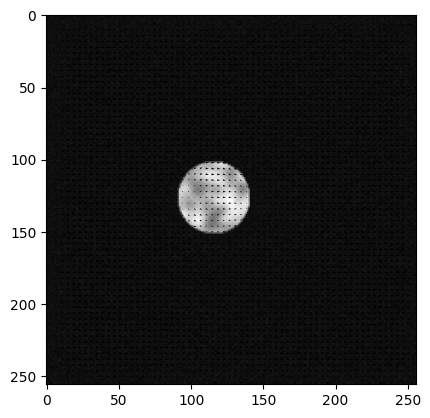

In [118]:
mvf,prediction = me_ssd(im_noise2, im_ball,32,32,10,lamb)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im_noise2, im_ball, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_noise2,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

Regularization


9.487722110300009
0.9786394294044376


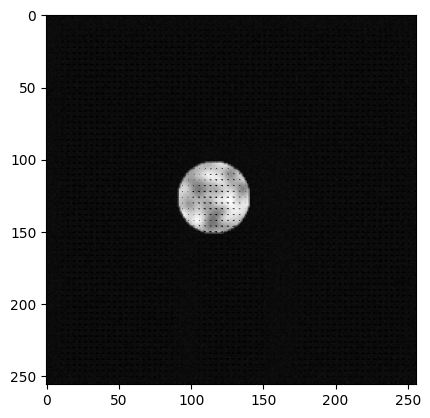

In [119]:
mvf,prediction = me_ssd(im_without_noise, im_ball,32,32,10,lamb=5)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im_without_noise, im_ball, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im_without_noise,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

Both Methods have worked well for the Lena and the ball image, with the appropriate regularization parameters(```alpha``` and ```lamb```).Noise affects a little bit the perfomance, but the results are still pretty good. 

As the block matching take the median, it seems to be more robust to the noise. Also, when the noise is too high, it's necessary to adapt the search kernel.

Finally, for non integer translation, we can check that the direct parametric estimation is no longer consistent, once there's nno more a linear phase signal as the ratio of DFTS. On the other hand, the indirect parametric mathods seems to work better, more specifically the block-matching.

